In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)


In [2]:
# Fixing the directory path 
import os
os.chdir("C:/Users/RAZER BLADE/Downloads/AI Path/Multi-Class-Classification")

In [3]:
data = pd.read_csv("Datasets/train.csv")

In [4]:
# log loss function 
def log_loss(Y_test, y_pred_proba):
    """
    Calcule l'opposé de la log-vraisemblance pour un problème de classification multiclasse.
    
    :param Y_test: ndarray de shape (N, M), les vérités terrain encodées en one-hot (1 pour la classe vraie, 0 sinon).
    :param y_pred: ndarray de shape (N, M), les probabilités prédites pour chaque classe.
                   Chaque ligne doit contenir les probabilités non normalisées.
    :return: float, la log-vraisemblance négative normalisée.
    """
    # Normaliser les probabilités
    y_pred_proba = y_pred_proba / np.sum(y_pred_proba, axis=1, keepdims=True)
    
    # Éviter les extrêmes du logarithme
    epsilon = 1e-15
    y_pred_proba = np.clip(y_pred_proba, epsilon, 1 - epsilon)

    N = Y_test.shape[0]
    M = y_pred_proba.shape[1]
    y_one_hot = np.zeros((N, M))
    y_one_hot[np.arange(N), Y_test] = 1
    
    # Calcul de la log-vraisemblance
    log_loss = -np.sum(y_one_hot * np.log(y_pred_proba)) / Y_test.shape[0]
    
    return log_loss

# Evaluation function with multiple metrics 
def evaluate_model(Y_test, Y_pred, y_pred_proba):

    loglosss = log_loss(Y_test, y_pred_proba)
    accuracy = accuracy_score(Y_test, Y_pred)
    precision = precision_score(Y_test, Y_pred, average='micro')
    recall = recall_score(Y_test, Y_pred, average='micro')
    f1 = f1_score(Y_test, Y_pred, average='micro')
    
    return accuracy, precision, recall, f1, loglosss

In [5]:
# Initialize the set of models 
models = {
    'k-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),  # Default k=5
    'Decision Tree': DecisionTreeClassifier(max_depth=None, random_state=42),
    'Naive Bayes': GaussianNB(),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
    'xgboost': XGBClassifier( n_estimators=100, max_depth=200)
}

In [41]:
def trainning_models(models, X_train, Y_train, X_test, Y_test):
    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train, Y_train) # Train model

        # Make predictions
        Y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)

        # Evaluate Test dataset
        accuracy, precision, recall, f1, logloss = evaluate_model(Y_test, Y_pred, y_pred_proba)
        print(model)
        print("Accuracy: {0}".format(accuracy))
        print("Precision: {0}".format(precision))
        print("Recall: {0}".format(recall))
        print("f1: {0}".format(f1))
        print("logloss: {0}".format(logloss))
        
        # Confusion Matrix
        cm = confusion_matrix(Y_test, Y_pred)
        plt.figure()
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(Y_test.unique()), yticklabels=list(Y_test.unique()))
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.xticks(rotation=0)
        plt.tight_layout()
        plt.gca().xaxis.set_label_position('top')  # Move x-axis label to the top
        plt.gca().xaxis.tick_top()                # Move x-axis ticks to the top
        plt.show()

        print('='*35)
        print('\n')

In [ ]:
trainning_models(models, X_train_final, Y_train_final.to_numpy(), X_test_final, Y_test_final)

In [7]:
import sys
from dataclasses import dataclass

import numpy as np 
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder,StandardScaler, OrdinalEncoder, RobustScaler
from sklearn.experimental import enable_iterative_imputer

from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.linear_model import LinearRegression

from src.exception import CustomException
from src.logger import logging
import os
from sklearn.compose import ColumnTransformer
import pandas as pd


# Modular Pipelines

# Imputing Nan values

In [8]:
def imputing_numerical(X_train_num, X_test_num):
        imputer = IterativeImputer(estimator=LinearRegression(), max_iter=10, random_state = 0)
        imputer.fit(X_train_num)
        X_train_num_imputed = imputer.transform(X_train_num)
        X_test_num_imputed = imputer.transform(X_test_num)

        X_train_num_imputed = pd.DataFrame(X_train_num_imputed)
        X_train_num_imputed.columns = X_train_num.columns
        X_test_num_imputed = pd.DataFrame(X_test_num_imputed)
        X_test_num_imputed.columns = X_test_num.columns
        return X_train_num_imputed, X_test_num_imputed

def imputing_categorical(df_fill):
    for col in df_fill.columns:
        if df_fill[col].isna().any():
            df_fill.loc[:, col] = df_fill[col].fillna(df_fill[col].mode()[0])
    return df_fill


# Encoding 

In [43]:
def encoding_mixed(X_train_cat_imputed, X_test_cat_imputed, onehot_cols, ordinal_cols):
    # Define the transformers for one-hot and ordinal encoding
    transformers = [
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), onehot_cols),
        ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ordinal_cols)
    ]

    # Create the ColumnTransformer
    column_transformer = ColumnTransformer(transformers, remainder='passthrough')

    # Fit the transformer on the training set and transform both datasets
    X_train_encoded = column_transformer.fit_transform(X_train_cat_imputed)
    X_test_encoded = column_transformer.transform(X_test_cat_imputed)

    # Get feature names for one-hot encoded columns
    onehot_feature_names = column_transformer.named_transformers_['onehot'].get_feature_names_out(onehot_cols)

    # Combine the one-hot and ordinal column names
    all_columns = list(onehot_feature_names) + ordinal_cols + [
        col for col in X_train_cat_imputed.columns if col not in onehot_cols + ordinal_cols
    ]

    # Convert to DataFrame with proper column names
    X_train_encoded = pd.DataFrame(X_train_encoded, columns=all_columns, index=X_train_cat_imputed.index)
    X_test_encoded = pd.DataFrame(X_test_encoded, columns=all_columns, index=X_test_cat_imputed.index)

    return X_train_encoded, X_test_encoded


def target_encoding(Y):
    code = {'C':0,'CL':1, 'D':2}
    Y = Y.map(code)
    return Y


# Scaling 

In [44]:
def scaling(X_train, X_test):
    X_train_tf = X_train.copy()
    X_test_tf = X_test.copy()

    log_features = ['N_Days', 'Bilirubin', 'Cholesterol', 'Alk_Phos', 'SGOT', 'Tryglicerides']
    numerical_features = [col for col in X_train.select_dtypes('float').columns if col not in log_features and col != 'Stage']
    
    # only scale numeric varaibles in this case rather than the dummy variables for categories 
    rob = RobustScaler()
    X_train_tf.loc[:, numerical_features] = rob.fit_transform(X_train_tf.loc[:, numerical_features])
    X_test_tf.loc[:, numerical_features] = rob.transform(X_test_tf.loc[:, numerical_features])

    # log 
    X_train_tf.loc[:, log_features] = X_train_tf.loc[:, log_features].apply(np.log1p)
    X_test_tf.loc[:, log_features] = X_test_tf.loc[:, log_features].apply(np.log1p)


    return X_train_tf, X_test_tf


In [63]:
def feature_engineering_numerical(X_num):

    X_num.loc[:, 'Age'] = X_num['Age'] / 365
    X_num['Bilirubin / Albumin'] = X_num['Bilirubin'] / X_num['Albumin']
    X_num['SGOT / Platelets'] = X_num['SGOT'] / X_num['Platelets']
    X_num['ISH'] = 0.4 * X_num['Cholesterol'] + 0.4 * X_num['Tryglicerides'] + 0.2 * X_num['Albumin']
    X_num['Coagulation_Score'] = X_num['Prothrombin'] / X_num['Platelets']

    return X_num

def feature_engineering_categorical(X_cat):
    #X_cat["Severe_Water_Retention"] = (X_cat["Edema"]  & X_cat["Ascites"])

    return X_cat


    

# Global Transformation function 

In [55]:
def initiate_data_transformation(dataset):

    # Specifiyng columns
    target_column_name = "Status"
    numerical_columns = ['N_Days', 'Bilirubin', 'Cholesterol', 
                        'Albumin', 'Copper', 'Alk_Phos',
                        'SGOT', 'Tryglicerides', 'Platelets', 
                        'Prothrombin', 'Age']
    categorical_columns = ['Stage','Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']
    columns_delete = ['id']

    # Splitting the matrices 
    dataset['Stage'] = dataset['Stage'].astype(object)
    Y = dataset[target_column_name]
    X = dataset.drop([target_column_name] + columns_delete, axis=1)

    # Basic preprocessing 
    X.loc[X['Hepatomegaly'] == '119.35', 'Hepatomegaly'] = X['Hepatomegaly'].mode()[0]
    X.loc[X['Ascites'] == 'S', 'Ascites'] = X['Ascites'].mode()[0]
    X.loc[X['Ascites'] == 'D-penicillamine', 'Ascites'] = X['Ascites'].mode()[0]
    


    
    # Preparing the X_train, Y_train, X_test, Y_test with stratified method
    X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.1, random_state=42, stratify=Y)

    # SPLITTING Categorical and numerical 

    # Train 
    X_train_num = X_train[numerical_columns]
    X_train_cat = X_train[categorical_columns]
    # Test 
    X_test_num = X_test[numerical_columns]
    X_test_cat = X_test[categorical_columns]



    # Imputing Data (Null Values)
    # For numerical Features 
    X_train_num_imputed, X_test_num_imputed = imputing_numerical(X_train_num, X_test_num)
    # For Categorical Features
    X_train_cat_imputed, X_test_cat_imputed = imputing_categorical(X_train_cat), imputing_categorical(X_test_cat)
                

    # Feature engineering 

    # Encoding Categorical Features
    onehot_cols = ['Edema']  # one-hot encoded column names
    ordinal_cols = ['Ascites', 'Drug', 'Sex', 'Hepatomegaly','Spiders', 'Stage']  # ordinal encoded column names
    X_train_cat_encoded, X_test_cat_encoded = encoding_mixed(X_train_cat_imputed, X_test_cat_imputed, onehot_cols, ordinal_cols)
    #X_train_cat_encoded, X_test_cat_encoded = encoding_target_kfold(X_train_cat_imputed, X_test_cat_imputed, Y_train, cat_cols=categorical_columns, n_splits=5)

    # Target Encoding 
    Y_train_final = target_encoding(Y_train)
    Y_test_final = target_encoding(Y_test)

    # Custom Feature functions 
    X_train_num_ft, X_test_num_ft = feature_engineering_numerical(X_train_num_imputed), feature_engineering_numerical(X_test_num_imputed) 
    X_train_cat_ft, X_test_cat_ft = feature_engineering_categorical(X_train_cat_encoded), feature_engineering_categorical(X_test_cat_encoded)



    # Scaling numerical Features
    X_train_tf, X_test_tf = scaling(X_train_num_ft, X_test_num_ft) 
    

    # Final concatenation of numerical and categorical features into one Dataset

    X_train_final = pd.concat([X_train_tf.reset_index().drop('index', axis=1), X_train_cat_ft.reset_index().drop('index', axis=1)], axis=1)
    X_test_final = pd.concat([X_test_tf.reset_index().drop('index', axis=1), X_test_cat_ft.reset_index().drop('index', axis=1)], axis=1)


    return (
        X_train_final,
        X_test_final,
        Y_train_final,
        Y_test_final
    )

In [64]:
X_train_final, X_test_final, Y_train_final, Y_test_final = initiate_data_transformation(data)

In [71]:
# This is a function to optimize 
def model_fit(X_new, Y_train, X_test_final, Y_test_final):
    model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
    model.fit(X_new, Y_train) # Train model

    # Make predictions
    Y_pred = model.predict(X_test_final[X_new.columns])
    y_pred_proba = model.predict_proba(X_test_final[X_new.columns])

    # Evaluate Test dataset
    _, _, _, _, logloss = evaluate_model(Y_test_final, Y_pred, y_pred_proba)
    print("logloss: {0}".format(logloss))
model_fit(X_train_final, Y_train_final, X_test_final, Y_test_final)

logloss: 0.37367960159912217


# Feature Selection 

25


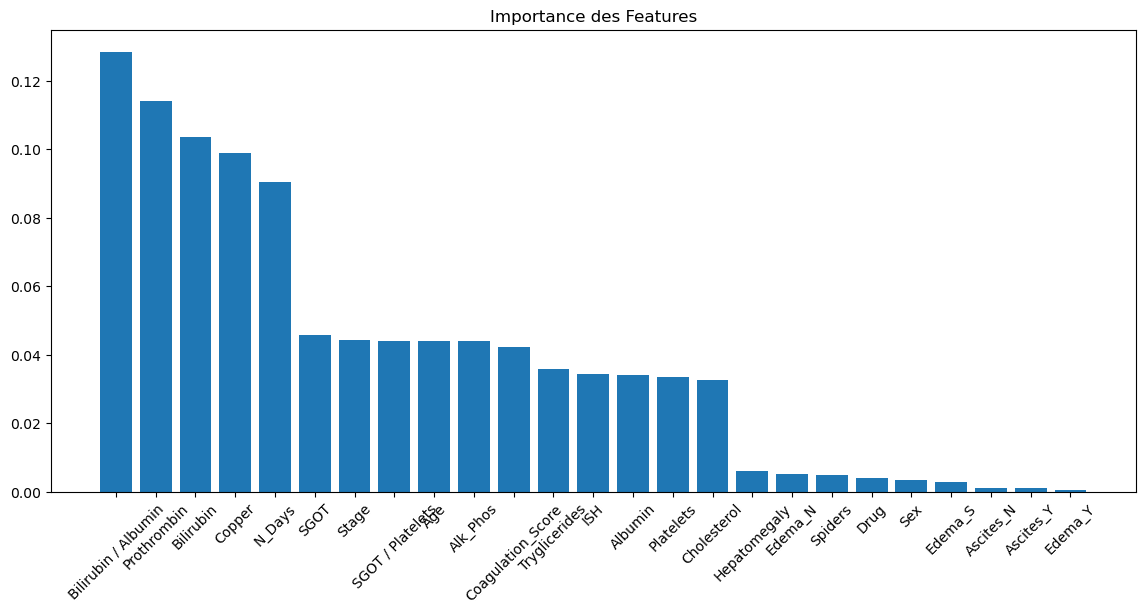

Features sélectionnées : ['Bilirubin / Albumin', 'Prothrombin', 'Bilirubin', 'Copper', 'N_Days', 'SGOT', 'Stage', 'SGOT / Platelets', 'Age', 'Alk_Phos', 'Coagulation_Score', 'Tryglicerides', 'ISH', 'Albumin', 'Platelets', 'Cholesterol']
Features sélectionnées : 16
logloss: 0.37534029644089517


In [ ]:
# Entraînement d'un modèle basique
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_final, Y_train_final)

# Récupérer l'importance des features
importances = model.feature_importances_
features = X_train_final.columns

# Trier les features par importance
indices = np.argsort(importances)[::-1]
print(len(indices))
# Affichage des 10 features les plus importantes
plt.figure(figsize=(14, 6))
plt.title("Importance des Features")
plt.bar(range(25), importances[indices[:]], align="center")
plt.xticks(range(25), [features[i] for i in indices[:25]], rotation=45)
plt.show()

# Définir le seuil d'importance des features
threshold = 0.01

# Sélectionner les features importantes
selected_features = [features[i] for i in indices if importances[i] > threshold]

# Afficher les features sélectionnées
print("Features sélectionnées :", selected_features)

# Créer un nouveau DataFrame avec uniquement ces features
print("Features sélectionnées :", len(selected_features))

def model_fit(X_new, Y_train, X_test_final, Y_test_final):
    model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
    model.fit(X_new, Y_train) # Train model

    # Make predictions
    Y_pred = model.predict(X_test_final[X_new.columns])
    y_pred_proba = model.predict_proba(X_test_final[X_new.columns])

    # Evaluate Test dataset
    accuracy, precision, recall, f1, logloss = evaluate_model(Y_test_final, Y_pred, y_pred_proba)
    print("logloss: {0}".format(logloss))

model_fit(X_train_final[selected_features], Y_train_final, X_test_final, Y_test_final)


# Model Hyper-tunning

#### Using RandomsearchCV

In [99]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

# Define XGBoost classifier
xgb = XGBClassifier(
    tree_method="hist",  
    eval_metric="mlogloss",  
    use_label_encoder=False
)

# Parameter grid
param_grid = {
    'n_estimators': [100, 300, 500, 1000],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.5, 1.0],
    'min_child_weight': [1, 3, 5, 10],
    'reg_lambda': [0.1, 1, 10],
    'reg_alpha': [0, 0.1, 1, 10],
    'scale_pos_weight': [1, 5, 10],  # Not usually needed for multiclass but can be tested
    'objective': ['multi:softprob'],  # Probabilities for multiclass classification
}

# Randomized search
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=30,  # Adjust based on available time/resources
    scoring='neg_log_loss',  # Log loss for multiclass
    cv=5,  # 5-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1  # Use all CPU cores
)

# Fit model (Assuming X_train, y_train are defined)
random_search.fit(X_train_final, Y_train_final)

# Best parameters and model
print("Best parameters:", random_search.best_params_)
best_model = random_search.best_estimator_

best_model.fit(X_train_final,Y_train_final)
Y_pred = best_model.predict(X_test_final)
y_pred_proba = best_model.predict_proba(X_test_final)

    # Evaluate Test dataset
accuracy, precision, recall, f1, logloss = evaluate_model(Y_test_final, Y_pred, y_pred_proba)
print("logloss: {0}".format(logloss))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters: {'subsample': 0.8, 'scale_pos_weight': 1, 'reg_lambda': 1, 'reg_alpha': 1, 'objective': 'multi:softprob', 'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 0.8}


In [ ]:
!pip install scikit-optimize

### Using BayesSearchCV

In [ ]:
from skopt import BayesSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split

# Define XGBoost model
xgb = XGBClassifier(
    tree_method="hist",  # Optimized for performance
    eval_metric="mlogloss",  # Log loss for multiclass classification
    use_label_encoder=False
)

# Bayesian Search Parameter Grid
param_grid = {
    'n_estimators': (100, 1000),  # Number of boosting rounds
    'max_depth': (3, 12),  # Tree depth
    'learning_rate': (0.01, 0.3, 'log-uniform'),  # Log scale for better selection
    'subsample': (0.5, 1.0),  # Fraction of data per tree
    'colsample_bytree': (0.5, 1.0),  # Fraction of features per tree
    'gamma': (0, 2.0),  # Minimum loss reduction
    'min_child_weight': (1, 10),  # Minimum sum of instance weight
    'reg_lambda': (0.01, 10.0, 'log-uniform'),  # L2 regularization
    'reg_alpha': (0.01, 10.0, 'log-uniform'),  # L1 regularization
}

# Define Bayesian Optimization Search
bayes_search = BayesSearchCV(
    estimator=xgb,
    search_spaces=param_grid,
    scoring='neg_log_loss',  # Minimizing log loss
    n_iter=30,  # Adjust based on time and resources
    cv=5,  # 5-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1  # Use all CPU cores
)

# Fit model (Assuming X_train, y_train are defined)
bayes_search.fit(X_train_final, Y_train_final)

# Best parameters and model
print("Best parameters:", bayes_search.best_params_)
best_model = bayes_search.best_estimator_

best_model.fit(X_train_final,Y_train_final)
Y_pred = best_model.predict(X_test_final)
y_pred_proba = best_model.predict_proba(X_test_final)

    # Evaluate Test dataset
accuracy, precision, recall, f1, logloss = evaluate_model(Y_test_final, Y_pred, y_pred_proba)
print("logloss: {0}".format(logloss))


### Prediction Pipeline 

In [15]:
test = pd.read_csv('Datasets/test.csv')

In [16]:
def transform_test_data(test_dataset):

    # Specifying columns for the transformation pipeline
    numerical_columns = ['N_Days', 'Bilirubin', 'Cholesterol', 
                         'Albumin', 'Copper', 'Alk_Phos',
                         'SGOT', 'Tryglicerides', 'Platelets', 
                         'Prothrombin', 'Stage', 'Age']
    categorical_columns = ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']
    columns_delete = ['id']  # Exclude the 'id' column in the test set

    # Remove 'id' column from test dataset
    X_test = test_dataset.drop(columns_delete, axis=1)
    
    # Handling missing values (same as during training)
    X_test.loc[X_test['Hepatomegaly'] == '119.35', 'Hepatomegaly'] = X_test['Hepatomegaly'].mode()[0]
    X_test.loc[X_test['Ascites'] == 'S', 'Ascites'] = X_test['Ascites'].mode()[0]
    X_test.loc[X_test['Ascites'] == 'D-penicillamine', 'Ascites'] = X_test['Ascites'].mode()[0]

    # Split into numerical and categorical columns
    X_test_num = X_test[numerical_columns]
    X_test_cat = X_test[categorical_columns]

    # Imputation
    X_test_num_imputed = imputing_numerical(X_test_num, X_test_num)[1]  # Impute based on the test data itself
    X_test_cat_imputed = imputing_categorical(X_test_cat)  # Impute categorical features

    # Encoding categorical features
    onehot_cols = ['Ascites', 'Edema']  # one-hot encoded columns
    ordinal_cols = ['Drug', 'Sex', 'Hepatomegaly', 'Spiders']  # ordinal encoded columns
    X_test_cat_encoded = encoding_mixed(X_test_cat_imputed, X_test_cat_imputed, onehot_cols, ordinal_cols)[1]  # Only need the transformed test data

    # Feature engineering for numerical and categorical features
    X_test_num_ft = feature_engineering_numerical(X_test_num_imputed)
    X_test_cat_ft = feature_engineering_categorical(X_test_cat_encoded)

    # Scaling numerical features
    X_test_tf = scaling(X_test_num_ft, X_test_num_ft)[1]  # Only scale based on test data (no fitting here)

    # Final concatenation of transformed numerical and categorical features
    X_test_final = pd.concat([X_test_tf.reset_index(drop=True), 
                              X_test_cat_ft.reset_index(drop=True)], axis=1)

    return X_test_final

In [17]:
X_test_processed = transform_test_data(test)
best_model.fit(X_train_final, Y_train_final)
Y_pred = best_model.predict(X_test_processed)
y_pred_proba = best_model.predict_proba(X_test_processed)

NameError: name 'best_model' is not defined

In [117]:
submission_df = pd.DataFrame(y_pred_proba, columns=["Status_C", "Status_CL", "Status_D"])
ids = test["id"] 
submission_df.insert(0, "id", ids)
submission_df

In [119]:
submission_df.to_csv('artifact/submission.csv', index=False)

Features sélectionnées : ['Bilirubin / Albumin', 'Prothrombin', 'Bilirubin', 'Copper', 'N_Days', 'SGOT', 'Alk_Phos', 'SGOT / Platelets', 'Age', 'Stage', 'Coagulation_Score', 'Tryglicerides', 'Platelets', 'ISH', 'Cholesterol', 'Albumin', 'Hepatomegaly', 'Edema_N', 'Drug', 'Spiders', 'Sex', 'Edema_S']
Features sélectionnées : 22


logloss: 0.3893177210306325
